In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sympy as sp
import keras

In [2]:
# Get the list of available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    # Print information about each GPU
    for gpu in gpus:
        print("Name:", gpu.name)
        print("Device Type:", gpu.device_type)
else:
    print("No GPUs found. TensorFlow will use CPU.")

Name: /physical_device:GPU:0
Device Type: GPU


In [148]:
# The times used for training (those in the loss function)

t_i = [0,0,0,0,0,0,0]
T_i = [5, 10, 15, 20, 25, 30, 35]

# Functions definition

In [149]:
#Define the loss function, then it will be necessary:
#Simulate the GBM trajectories.
#Simulate the Gaussian variables.

def GBM(mu = 0.05, sigma = 0.02, n = 50, dt = 0.001, x0 = [100], batch_size = 64):

    #np.random.seed(1)

    result = tf.TensorArray(dtype = tf.float32, size = batch_size)

    x0 = tf.cast(x0, tf.float32)

    for i in range(batch_size):
        x = np.exp(
            (mu - sigma ** 2 / 2) * dt
            + sigma * np.random.normal(0, np.sqrt(dt), size=(1, n)).T
        )
        x = np.vstack([1, x])
        #x = np.concatenate(x, axis=0)
        partial = x.cumprod(axis=0)
        partial = x0[i] * partial[-1]     #return only last point of the GBM
        result = result.write(i, partial)
    #tf.print(result)

    result = result.stack()

    return result


def Martingale(output, batch_size=64):
    # Compute a batch extracted from a normal variable with variance given by the MLP output

    # Define a Normal distribution with TensorFlow
    random_value = tf.random.normal([batch_size], mean=0.0, stddev = output, dtype=tf.float32)

    return random_value

In [135]:
import tensorflow_probability as tfp

def compute_expected_value_tf(x_star, sigma1, strike, mu, sigma, Ti_k):
    """
    Compute the expected value of the call option payoff using TensorFlow given the parameters.

    Parameters:
    - x_star: Logarithm of the GBM values at maturity (Tensor, shape: (batch_size,)).
    - sigma1: The predicted standard deviation \(\sigma_1\) (Tensor, shape: (batch_size,)).
    - strike: The strike price of the call option (Tensor, shape: (batch_size,)).
    - mu: Tensor, the drift term of the GBM.
    - sigma: Tensor, the volatility parameter of the GBM.
    - Ti_k: Tensor, the maturity time in days (must be converted to years by multiplying by \(1/252\)).

    Returns:
    - The expected value of the call option payoff as a TensorFlow tensor.
    """
    
    # Convert Ti_k from days to years
    Ti_k_in_years = Ti_k / 252.0

    # Compute the combined lognormal variable Y = X* + M
    mu_Y = x_star + (mu - 0.5 * sigma**2) * Ti_k_in_years
    sigma_Y_squared = sigma**2 * Ti_k_in_years + sigma1**2  # Using sigma1^2 as the variance
    sigma_Y = tf.sqrt(sigma_Y_squared)

    # Calculate d1 and d2
    d1 = (mu_Y + sigma_Y_squared - tf.math.log(strike)) / sigma_Y
    d2 = d1 - sigma_Y

    # Use TensorFlow Probability to compute the normal CDF
    normal_dist = tfp.distributions.Normal(loc=0.0, scale=1.0)
    Phi_d1 = normal_dist.cdf(d1)
    Phi_d2 = normal_dist.cdf(d2)

    # Calculate the expected value using the correct normal CDF
    expected_value = tf.exp(mu_Y + 0.5 * sigma_Y_squared) * Phi_d1 - strike * Phi_d2

    return expected_value

# Simulated Data

In [136]:
from scipy.stats import norm

# Black-Scholes formula for European call options
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = (S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2))
    return call_price

# Black-Scholes formula for European put options
def black_scholes_put(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    put_price = (K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1))
    return put_price

In [137]:
import tensorflow as tf
import numpy as np

def GBM_full(mu=0.05, sigma=0.02, n=50, dt=0.001, x0=[100], batch_size=64):
    # Initialize a TensorArray to store full trajectories
    result = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=False, clear_after_read=False)

    # Convert x0 to a TensorFlow tensor
    x0 = tf.constant(x0, dtype=tf.float32)

    for i in range(batch_size):
        # Generate random samples using TensorFlow
        normal_samples = tf.random.normal([n], mean=0.0, stddev=np.sqrt(dt))
        # Calculate x values using TensorFlow
        x = tf.exp((mu - sigma**2 / 2) * dt + sigma * normal_samples)
        x = tf.concat([[1.0], x], axis=0)  # Start with 1 and append GBM increments
        # Cumulative product to simulate the GBM path
        trajectory = x0[i] * tf.math.cumprod(x)
        # Write the trajectory to the result TensorArray
        result = result.write(i, trajectory)

    # Stack all trajectories into a single tensor
    full_trajectories = result.stack()

    return full_trajectories

In [150]:
import tensorflow as tf
import numpy as np
from scipy.stats import norm

# Parameters for the entire simulation
total_batches = 200
batch_size = 100  # Size of each batch
n = 252  # Number of trading days in a year
dt = 1 / n  # Daily time step
T = 1  # Time to expiration in years
r = 0.00  # Risk-free interest rate

def simulate_batches(total_batches, batch_size, n, dt):
    all_stock_trajectories = []
    all_option_prices = []
    all_strike_prices = []

    for _ in range(total_batches):
        # Randomly vary mu, sigma, and K for each batch
        mu = np.random.uniform(2, 2.1)
        sigma = np.random.uniform(0.01, 0.05)
        K = np.random.uniform(90, 120)
        #start_x = np.random.uniform(90, 200, size=batch_size)
        start_x = K + np.random.normal(0, 5, size=batch_size)  # Some oprions are in the money, some are out of the money
        
        x0 = start_x
        stock_trajectories = GBM_full(mu, sigma, n, dt, x0, batch_size).numpy()
        option_prices = np.array([black_scholes_call(S, K, T, r, sigma) for S in stock_trajectories])
        strike_prices = np.full((batch_size, n), K)

        all_stock_trajectories.append(stock_trajectories)
        all_option_prices.append(option_prices)
        all_strike_prices.append(strike_prices)

    return np.vstack(all_stock_trajectories), np.vstack(all_option_prices), np.vstack(all_strike_prices)

stock_trajectories, option_prices, strike_prices = simulate_batches(total_batches, batch_size, n, dt)

x_train = stock_trajectories

y_train = np.hstack([stock_trajectories[:, t_i], strike_prices[:, t_i], option_prices[:, np.add(t_i, T_i)], stock_trajectories[:, np.add(t_i, T_i)]], dtype=np.float32)


In [148]:
y_train.shape

(20000, 28)

# Training

In [151]:
TSlenght = 253

times = t_i             #the t_i
maturities = T_i        #the T_i

lambd = 0.05

def custom_initializer(shape, dtype=None):
    return tf.random.normal(shape, mean=0.0, stddev=0.1, dtype=dtype)

def scaled_sigmoid_activation(x):
    return 5 * tf.keras.activations.sigmoid(x)

# Define the two sub-activation functions
def sigma_1(x):
    return tf.abs(x - 2 * tf.floor((x + 1) / 2))

def sigma_2(x):
    return x / (tf.abs(x) + 1)

# Define the Fancy activation function
@tf.function
def fancy_activation(x):
    return tf.where(x >= 0, sigma_1(x), sigma_2(x))

# Create a simple model using sine activation functions
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation=fancy_activation, kernel_initializer=custom_initializer, input_shape=(TSlenght+1,)),  # Using sine activation
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation=fancy_activation, kernel_initializer=custom_initializer),  # Using sine activation
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation='sigmoid', kernel_initializer=custom_initializer),  # Using sine activation
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer with sigmoid activation  # TRY WITHOUT
])

Epoch 0, Step 0.0, Loss: 1957.7916259765625
Epoch 0, Step 10.0, Loss: 904.4968872070312
Epoch 0, Step 20.0, Loss: 521.0741577148438
Epoch 0, Step 30.0, Loss: 365.0090026855469
Epoch 0, Step 40.0, Loss: 266.4054260253906
Epoch 0, Step 50.0, Loss: 215.5551300048828
Epoch 0, Step 60.0, Loss: 139.91818237304688
Epoch 0, Step 70.0, Loss: 116.30115509033203
Epoch 0, Step 80.0, Loss: 83.43412780761719
Epoch 0, Step 90.0, Loss: 72.89334869384766
Epoch 0, Step 100.0, Loss: 52.91013717651367
Epoch 0, Step 110.0, Loss: 52.99325180053711
Epoch 0, Step 120.0, Loss: 38.477447509765625
Epoch 0, Step 130.0, Loss: 35.89081954956055
Epoch 0, Step 140.0, Loss: 27.05582618713379
Epoch 0, Step 150.0, Loss: 23.120798110961914
Epoch 0, Step 160.0, Loss: 24.645355224609375
Epoch 0, Step 170.0, Loss: 17.827713012695312
Epoch 0, Step 180.0, Loss: 13.369732856750488
Epoch 0, Step 190.0, Loss: 17.92059898376465
Epoch 0, Step 200.0, Loss: 15.791743278503418
Epoch 0, Step 210.0, Loss: 16.29527473449707
Epoch 0, Ste

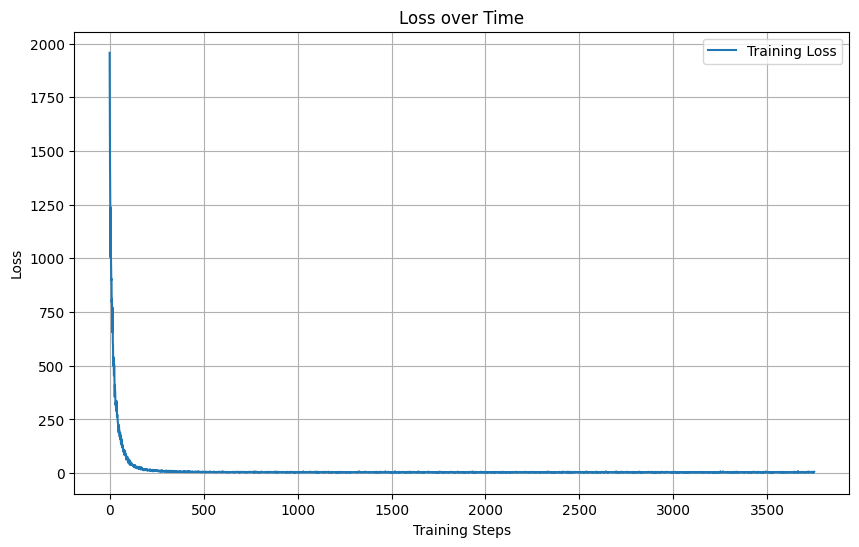

In [152]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Number of epochs, batch size, etc.
dataset_size = len(x_train)  # Total number of samples in the dataset
tf.config.run_functions_eagerly(True) 

N = len(times)
learning_rate = 0.001
epochs = 3
mini_batch = 16

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# List to store the loss values
loss_history = []

# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step(x_train, y_train):
    for epoch in range(epochs):
        indices = np.arange(dataset_size)
        np.random.shuffle(indices)
        x_train_shuffled = tf.gather(x_train, indices)
        y_train_shuffled = tf.gather(y_train, indices)
        
        # Iterate over the entire dataset once per epoch
        for step in range(0, dataset_size, mini_batch):
            # Get the batch of data
            batch_indices = indices[step:step + mini_batch]
            x_batch = tf.gather(x_train_shuffled, batch_indices)
            y_batch = tf.gather(y_train_shuffled, batch_indices)

            # Compute loss
            with tf.GradientTape() as tape:

                # Extracting necessary columns from y_batch
                ind = tf.constant(np.linspace(0, N - 1, N, dtype=int))
                x = tf.transpose(tf.nn.embedding_lookup(tf.transpose(y_batch), ind))

                ind = tf.constant(np.linspace(N, 2 * N - 1, N, dtype=int))
                strike = tf.transpose(tf.nn.embedding_lookup(tf.transpose(y_batch), ind))

                ind = tf.constant(np.linspace(2 * N, 3 * N - 1, N, dtype=int))
                g = tf.transpose(tf.nn.embedding_lookup(tf.transpose(y_batch), ind))

                ind = tf.constant(np.linspace(3 * N, 4 * N - 1, N, dtype=int))
                x_fin = tf.transpose(tf.nn.embedding_lookup(tf.transpose(y_batch), ind))

                # Convert to float32
                x = tf.cast(x, tf.dtypes.float32)
                strike = tf.cast(strike, tf.dtypes.float32)
                g = tf.cast(g, tf.dtypes.float32)
                x_fin = tf.cast(x_fin, tf.dtypes.float32)

                max_losses = []  # Create an array to store the maximum loss for each iteration

                for i in range(N):  # Loop over all time points t_i
                    dtype = x_batch.dtype

                    # Time column to add at the end of x_batch (our MLP takes the time to output the correct variance)
                    time_maturity_column = tf.cast(tf.fill([mini_batch, 1], times[i] + maturities[i]), dtype)

                    # Concatenate the new column to x_batch
                    x_batch_time = tf.concat([x_batch, time_maturity_column], axis=1)

                    # Get predictions from the model
                    y_pred = model(x_batch_time, training=True)

                    # Compute the log of the underlying GBM (X*)
                    x_star = tf.math.log(GBM(mu=1, sigma=0.04, n=maturities[i], dt=1/252, x0=x[:, i], batch_size=mini_batch))
                    x_star = tf.cast(x_star, tf.dtypes.float32)

                    # In order to have [0,1,2,...] instead of [[0],[1],[2],...]
                    x_star = tf.squeeze(x_star)
                    g = tf.squeeze(g)

                    # Compute the martingale process, which is our variance \(\sigma_1^2\)
                    mart = y_pred  # y_pred directly represents \(\sigma_1^2\)
                    mart = tf.cast(mart, tf.dtypes.float32)

                    # Compute the expected value using our updated function
                    expected_value = compute_expected_value_tf(x_star, mart, strike[:, i], mu=1, sigma=0.04, Ti_k=maturities[i])

                    # Compute the loss as the difference between the expected value and the intrinsic value
                    intrinsic_value = tf.math.maximum(x_fin[:, i] - strike[:, i], tf.constant([0], dtype=tf.float32))
                    loss = tf.square(expected_value - intrinsic_value) + tf.exp(-lambd * times[i]) * y_pred**2  # including regularization
                    loss = tf.math.reduce_mean(loss)

                    # Append the loss to the array of losses
                    max_losses.append(loss)

                # Take the mean of the loss array
                loss_value = tf.reduce_mean(max_losses)

            # Compute gradients and update model parameters
            gradients = tape.gradient(loss_value, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            # Append the loss value to the loss history
            loss_history.append(loss_value.numpy())

            # Print loss every n steps
            if step % (mini_batch * 10) == 0:
                print(f"Epoch {epoch}, Step {step / mini_batch}, Loss: {loss_value.numpy()}")

# Train the model
train_step(x_train, y_train)

# Plot the loss over time
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Training Loss')
plt.title('Loss over Time')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Test data

In [153]:
import tensorflow as tf
import numpy as np

# Parameters for the entire simulation
total_batches = 20
batch_size = 100  # Size of each batch
n = 252  # Number of trading days in a year
dt = 1 / n  # Daily time step
T = 1  # Time to expiration in years
r = 0.00  # Risk-free interest rate

def simulate_batches(total_batches, batch_size, n, dt):
    all_stock_trajectories = []
    all_option_prices = []
    all_strike_prices = []

    for _ in range(total_batches):
        # Randomly vary mu, sigma, and K for each batch
        mu = np.random.uniform(2, 2.1)
        sigma = np.random.uniform(0.01, 0.05)
        K = np.random.uniform(90, 120)
        #start_x = np.random.uniform(90, 200, size=batch_size)
        start_x = K + np.random.normal(0, 5, size=batch_size)
        
        x0 = start_x
        stock_trajectories = GBM_full(mu, sigma, n, dt, x0, batch_size).numpy()
        option_prices = np.array([black_scholes_call(S, K, T, r, sigma) for S in stock_trajectories])
        strike_prices = np.full((batch_size, n), K)

        all_stock_trajectories.append(stock_trajectories)
        all_option_prices.append(option_prices)
        all_strike_prices.append(strike_prices)

    return np.vstack(all_stock_trajectories), np.vstack(all_option_prices), np.vstack(all_strike_prices)

stock_trajectories, option_prices, strike_prices = simulate_batches(total_batches, batch_size, n, dt)

x_test = stock_trajectories

y_test = np.hstack([stock_trajectories[:, t_i], strike_prices[:, t_i], option_prices[:, np.add(t_i, T_i)], stock_trajectories[:, np.add(t_i, T_i)]], dtype=np.float32)

In [152]:
y_test.shape


(2000, 28)

# Testing

In [ ]:
# Code for testing the model

average, average_mart, delta = 0, 0, 0

M = len(times)

#These are arrays of lenght = self.times and size = mini_batch with all the x_i, strike_i and g_i needed
ind = tf.constant(np.linspace(0,M-1,M, dtype=int))
x = tf.transpose(tf.nn.embedding_lookup(tf.transpose(y_test), ind))

ind = tf.constant(np.linspace(M,2*M-1,M, dtype=int))
strike = tf.transpose(tf.nn.embedding_lookup(tf.transpose(y_test), ind))

ind = tf.constant(np.linspace(2*M,3*M-1,M, dtype=int))
g = tf.transpose(tf.nn.embedding_lookup(tf.transpose(y_test), ind))

# Number of trials for the MC computation
N = 2000

# times ahead to predict
t = 80

# For visualizing the progresses
import tqdm

# We try it for 20 different TS
for i in range(5):

    x_0 = tf.convert_to_tensor(x_test[i], dtype = tf.float32)

    # Create the time_maturity_column tensor with the same dtype
    time_maturity_column = tf.cast(tf.fill([1, 1], t), tf.float32)

    # Concatenate this new column to the first row tensor
    x_batch_time = tf.concat([[x_0], time_maturity_column], axis=1)

    # Compute the variance at time t
    var = model.predict(x_batch_time, verbose=None)

    x_0 = [x_0[0]] # Initial value (time t=0)

    it = tqdm.tqdm(total = N)

    for j in range(N):
        # delta between predicted option price with GBM and actual value

        x_star = np.log(GBM(mu = 1, sigma = 0.04, n = t, dt = 1/252, x0 = x_0, batch_size = 1).numpy())

        average += np.abs(np.maximum(np.exp(x_star)-strike[i,6].numpy(), 0) - g[i,6].numpy())/g[i,6].numpy()

        # Sample the martingale
        mart = Martingale(var, 1)

        # delta between predicted option price with GBM + martingale and actual value

        average_mart += np.abs(np.maximum(np.exp(x_star + mart)-strike[i,6].numpy(), 0) - g[i,6].numpy())/g[i,6].numpy()

        #print(x_star, mart.numpy(), np.exp(x_star + mart), strike[i*5,0].numpy(), g[i*5,0].numpy())

        it.update(1)
    it.close()

    average = average/N
    average_mart = average_mart/N

    print("Only GBM:", average)
    print("GBM + Martingale:", average_mart)

    delta += average - average_mart

    average, average_mart = 0, 0

print("Global delta:", delta)

# Plots

Predicting at horizon 200 days: 100%|██████████| 1000/1000 [00:02<00:00, 467.85it/s]


0.57789046
0.5759547


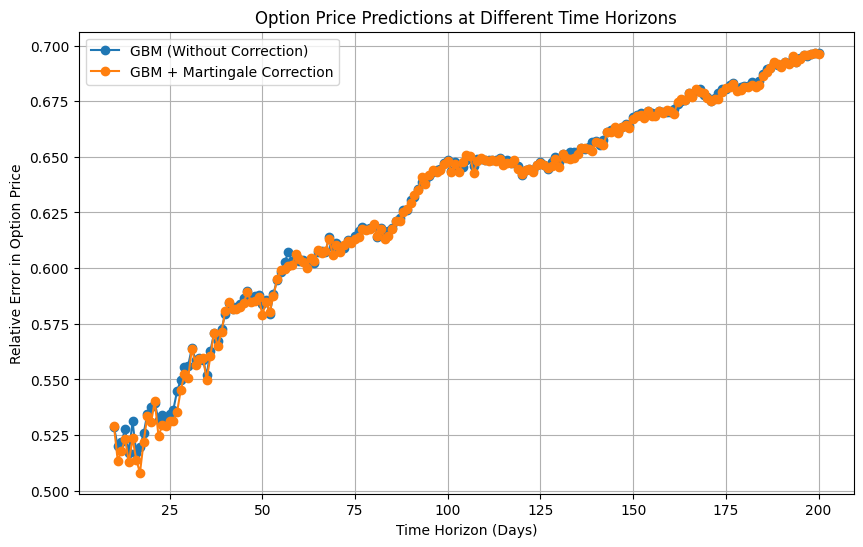

In [154]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Number of trials for the MC computation
N = 1000
# Time horizons to predict
time_horizons = np.arange(10, 201, 1)  # Predict at horizons 10, 20, 30, 40

M = len(times)

#These are arrays of lenght = self.times and size = mini_batch with all the x_i, strike_i and g_i needed
ind = tf.constant(np.linspace(0,M-1,M, dtype=int))
x = tf.transpose(tf.nn.embedding_lookup(tf.transpose(y_test), ind))

ind = tf.constant(np.linspace(M,2*M-1,M, dtype=int))
strike = tf.transpose(tf.nn.embedding_lookup(tf.transpose(y_test), ind))

ind = tf.constant(np.linspace(2*M,3*M-1,M, dtype=int))
g = tf.transpose(tf.nn.embedding_lookup(tf.transpose(y_test), ind))

# Initialize arrays for storing results
gbm_prices = []
gbm_mart_prices = []

# Test a single time series
x_0 = tf.convert_to_tensor(x_test[0], dtype=tf.float32)  # Using the first time series as an example

# Consider all the times, not only those at which we trained
g = option_prices

# Loop over time horizons
for t in time_horizons:
    average, average_mart = 0, 0

    # Create the time_maturity_column tensor with the same dtype
    time_maturity_column = tf.cast(tf.fill([1, 1], t), tf.float32)

    # Concatenate the initial time series with the time column
    x_batch_time = tf.concat([[x_0], time_maturity_column], axis=1)

    # Compute the variance at time t using the model
    var = model.predict(x_batch_time, verbose=None)

    # Initial stock price
    x_0_value = [x_0[0].numpy()]  # Value at time t = 0

    # Monte Carlo simulation loop
    for j in tqdm(range(N), desc=f"Predicting at horizon {t} days"):
        # Predict future stock price with GBM
        x_star = np.log(GBM(mu=1, sigma=0.04, n=t, dt=1/252, x0=x_0_value, batch_size=1).numpy())

        # GBM-based option price prediction (no correction)
        gbm_price = np.maximum(np.exp(x_star) - strike[0, 0], 0)
        average += np.abs(gbm_price - g[0, t]) / g[0, t]

        # Martingale sampling
        mart = Martingale(var, 1)

        # GBM with martingale correction
        gbm_mart_price = np.maximum(np.exp(x_star + mart) - strike[0, 0], 0)
        average_mart += np.abs(gbm_mart_price - g[0, t]) / g[0, t]

    # Store average price predictions for both GBM and GBM+Martingale
    average /= N
    average_mart /= N
    gbm_prices.append(average.flatten())  # Ensure this is flattened
    gbm_mart_prices.append(average_mart.flatten())  # Ensure this is flattened

# Convert lists to 1D arrays for plotting
gbm_prices = np.array(gbm_prices).flatten()
gbm_mart_prices = np.array(gbm_mart_prices).flatten()

print(gbm_prices[0:75].mean())
print(gbm_mart_prices[0:75].mean())

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(time_horizons, gbm_prices, label='GBM (Without Correction)', marker='o')
plt.plot(time_horizons, gbm_mart_prices, label='GBM + Martingale Correction', marker='o')

plt.title('Option Price Predictions at Different Time Horizons')
plt.xlabel('Time Horizon (Days)')
plt.ylabel('Relative Error in Option Price')
plt.legend()
plt.grid(True)
plt.show()

In [155]:
print(gbm_prices[50:100].mean())
print(gbm_mart_prices[50:100].mean())

0.62529844
0.62488014


Predicting at horizon 100 days: 100%|██████████| 1000/1000 [00:01<00:00, 577.90it/s]


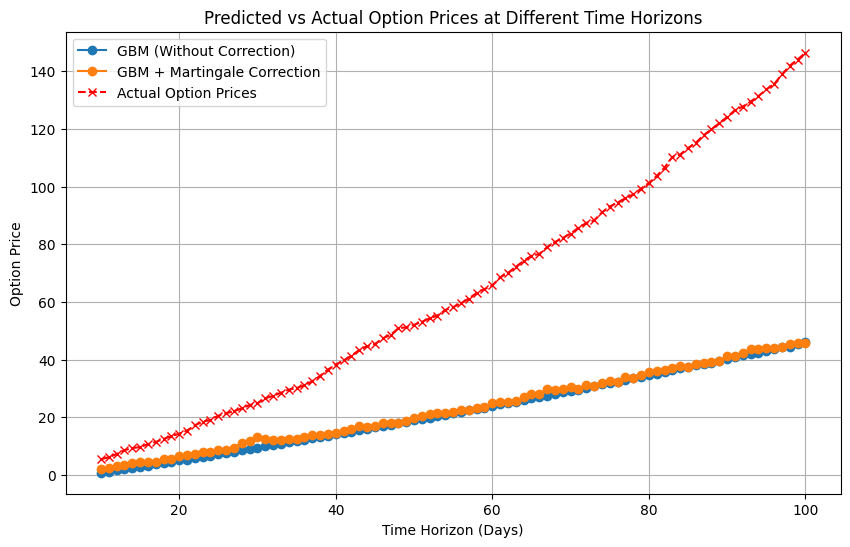

In [54]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Number of trials for the MC computation
N = 1000
# Time horizons to predict
time_horizons = np.arange(10, 101, 1)  # Predict at horizons 10, 20, 30, 40

# Initialize arrays for storing predicted prices and actual prices
gbm_prices = []
gbm_mart_prices = []
actual_prices = []

# Test a single time series
x_0 = tf.convert_to_tensor(x_test[0], dtype=tf.float32)  # Using the first time series as an example

# Consider all the times, not only those at which we trained
g = option_prices

# Loop over time horizons
for t in time_horizons:
    gbm_average_price, gbm_mart_average_price = 0, 0

    # Create the time_maturity_column tensor with the same dtype
    time_maturity_column = tf.cast(tf.fill([1, 1], t), tf.float32)

    # Concatenate the initial time series with the time column
    x_batch_time = tf.concat([[x_0], time_maturity_column], axis=1)

    # Compute the variance at time t using the model
    var = model.predict(x_batch_time, verbose=None)

    # Initial stock price
    x_0_value = [x_0[0].numpy()]  # Value at time t = 0

    # Monte Carlo simulation loop
    for j in tqdm(range(N), desc=f"Predicting at horizon {t} days"):
        # Predict future stock price with GBM
        x_star = np.log(GBM(mu=1, sigma=0.04, n=t, dt=1/252, x0=x_0_value, batch_size=1).numpy())

        # GBM-based option price prediction (no correction)
        gbm_price = np.maximum(np.exp(x_star) - strike[0, 0].numpy(), 0)
        gbm_average_price += gbm_price

        # Martingale sampling
        mart = Martingale(var, 1)

        # GBM with martingale correction
        gbm_mart_price = np.maximum(np.exp(x_star + mart) - strike[0, 0].numpy(), 0)
        gbm_mart_average_price += gbm_mart_price

    # Store average price predictions for both GBM and GBM+Martingale
    gbm_average_price /= N
    gbm_mart_average_price /= N
    gbm_prices.append(gbm_average_price.flatten())  # Ensure this is flattened
    gbm_mart_prices.append(gbm_mart_average_price.flatten())  # Ensure this is flattened

    # Extract the actual option price at the time horizon t
    actual_price = g[0, t]  # Assuming `g` contains the actual option prices
    actual_prices.append(actual_price)

# Convert lists to 1D arrays for plotting
gbm_prices = np.array(gbm_prices).flatten()
gbm_mart_prices = np.array(gbm_mart_prices).flatten()
actual_prices = np.array(actual_prices)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(time_horizons, gbm_prices, label='GBM (Without Correction)', marker='o')
plt.plot(time_horizons, gbm_mart_prices, label='GBM + Martingale Correction', marker='o')
plt.plot(time_horizons, actual_prices, label='Actual Option Prices', marker='x', linestyle='--', color='r')

plt.title('Predicted vs Actual Option Prices at Different Time Horizons')
plt.xlabel('Time Horizon (Days)')
plt.ylabel('Option Price')
plt.legend()
plt.grid(True)
plt.show()